In [1]:
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from pathFunc import dbPath, dataDir
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image

In [2]:
conn = sqlite3.connect(dbPath())
query_burg = """SELECT * FROM table_name
WHERE "Crime Type" = "Burglary"
"""
query_sun = """SELECT * FROM sunlight"""
query_house = """SELECT * FROM housing_by_lsoa"""
query_unep = """SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"""

df_burglary_all = pd.read_sql(query_burg, conn)
df_sunlight_all = pd.read_sql(query_sun, conn)
df_housing_all = pd.read_sql(query_house, conn)
df_unemployment_all = pd.read_sql(query_unep, conn)
#getting data from database and storing in DF
conn.close()

In [3]:
start_year = 2013 #what data you will process
end_year = 2022
train_lower, train_upper = 2014, 2018 #what data you give the model to train
test_lower, test_upper = 2019, 2019 #test years for model

In [4]:
df_unemployment = df_unemployment_all.rename(columns={'geogcode': 'LSOA code'}) 
df_unemployment['Month'] =  pd.to_datetime(df_unemployment['date'])
df_unemployment_5yr = df_unemployment[(df_unemployment['Month'].dt.year >= start_year) & (df_unemployment['Month'].dt.year <= end_year)]
df_unemployment_5yr = df_unemployment_5yr[df_unemployment_5yr['LSOA code'] != 'Column Total']
df_unemployment_5yr["Unemployment"] = df_unemployment_5yr["value"]
df_unemployment_5yr = df_unemployment_5yr.drop(columns=["date", "index", "value"], axis=1)
#filterig unemployment to 5 year time spand of 2014 to 2019 and renaming columns for compatibility 
#2013 included for time lag

In [5]:
lsoa_codes_bar = ['E01000115', 'E01000116', 'E01000117', 'E01000118', 'E01000119', 'E01000120', 'E01000121', 'E01000122', 'E01000123', 'E01000124', 'E01000125', 'E01000126', 'E01000127', 'E01000128', 'E01000129', 'E01000130', 'E01000131', 'E01000132', 'E01000133', 'E01000134', 'E01000135', 'E01000136', 'E01000137', 'E01000138', 'E01000139', 'E01000140', 'E01000141', 'E01000142', 'E01000143', 'E01000144', 'E01000145', 'E01000146', 'E01000147', 'E01000148', 'E01000150', 'E01000151', 'E01000152', 'E01000153', 'E01000154', 'E01000155', 'E01000156', 'E01000157', 'E01000158', 'E01000159', 'E01000160', 'E01000161', 'E01000162', 'E01000163', 'E01000164', 'E01000165', 'E01000166', 'E01000167', 'E01000168', 'E01000169', 'E01000170', 'E01000171', 'E01000172', 'E01000173', 'E01000174', 'E01000175', 'E01000176', 'E01000177', 'E01000178', 'E01000179', 'E01000180', 'E01000181', 'E01000182', 'E01000183', 'E01000184', 'E01000185', 'E01000186', 'E01000187', 'E01000188', 'E01000189', 'E01000190', 'E01000191', 'E01000192', 'E01000193', 'E01000194', 'E01000195', 'E01000196', 'E01000197', 'E01000198', 'E01000199', 'E01000200', 'E01000201', 'E01000202', 'E01000203', 'E01000204', 'E01000205', 'E01000206', 'E01000207', 'E01000208', 'E01000209', 'E01000210', 'E01000211', 'E01000212', 'E01000213', 'E01000214', 'E01000215', 'E01000216', 'E01000217', 'E01000218', 'E01000219', 'E01000220', 'E01000221', 'E01000222', 'E01000223', 'E01000224', 'E01000225', 'E01000226', 'E01000227', 'E01000228', 'E01000229', 'E01000230', 'E01000231', 'E01000232', 'E01000233', 'E01000234', 'E01000235', 'E01000236', 'E01000237', 'E01000238', 'E01000239', 'E01000240', 'E01000241', 'E01000242', 'E01000243', 'E01000244', 'E01000245', 'E01000246', 'E01000247', 'E01000248', 'E01000249', 'E01000250', 'E01000251', 'E01000252', 'E01000253', 'E01000254', 'E01000255', 'E01000256', 'E01000257', 'E01000258', 'E01000259', 'E01000260', 'E01000261', 'E01000262', 'E01000263', 'E01000264', 'E01000265', 'E01000266', 'E01000267', 'E01000268', 'E01000269', 'E01000270', 'E01000271', 'E01000272', 'E01000273', 'E01000274', 'E01000275', 'E01000276', 'E01000277', 'E01000278', 'E01000279', 'E01000280', 'E01000281', 'E01000282', 'E01000283', 'E01000284', 'E01000285', 'E01000286', 'E01000287', 'E01000288', 'E01000289', 'E01000290', 'E01000291', 'E01000292', 'E01000293', 'E01000294', 'E01000295', 'E01000296', 'E01000297', 'E01000298', 'E01000299', 'E01000300', 'E01000301', 'E01000302', 'E01000303', 'E01000304', 'E01000305', 'E01000306', 'E01000307', 'E01000308', 'E01000309', 'E01000310', 'E01000311', 'E01000312', 'E01000313', 'E01000314', 'E01000315', 'E01000316', 'E01000317', 'E01000318', 'E01000319', 'E01000320', 'E01000321', 'E01000322', 'E01000323', 'E01000324', 'E01033572', 'E01033573']

df_bar=df_burglary_all[df_burglary_all['LSOA code'].isin(lsoa_codes_bar)].drop(columns=['Reported by', 'Falls within'])
df_bar['Month'] = pd.to_datetime(df_bar['Month'])
df_bar['Year']= df_bar['Month'].dt.year
df_bar_5yr = df_bar[(df_bar['Month'].dt.year >= start_year) & (df_bar['Month'].dt.year <= end_year)]
#Filtering for Barnet data, 2013 included for time lag

In [6]:
df_sunlight_all['Month'] = pd.to_datetime(df_sunlight_all['Year-Month'])
df_sunlight=df_sunlight_all.drop(columns=["Year-Month", "index"], axis=1)
#Sunlight DF, ensuring compatibility by creating Datime Col

In [7]:
#df_housing = df_housing.drop(columns=["index"], axis=1)
#Housing dataframe
df_housing_clean = df_housing_all[["Proportion of indep", "Proportion small house", "Proportion social", "Proportion rented", "LSOA name",  "LSOA code" ]]

In [8]:
file_path =dataDir().joinpath("Household composition.xlsx")
df_grannies_all = pd.read_excel(file_path, sheet_name='2021')
df_grannies_all["Proportion old"]=df_grannies_all["One person Aged 66+"]/df_grannies_all['All households']
df_grannies=df_grannies_all[['LSOA code', 'One person Aged 66+', 'One person Aged up to 65','Family: all aged 66+', 'Proportion old']]

In [9]:
temp_burglaries_per_lsoa_month = df_bar_5yr[df_bar_5yr['Crime type'] == 'Burglary'].groupby(['LSOA code', 'Month']).size()
temp_burglaries_per_lsoa_month = temp_burglaries_per_lsoa_month.reset_index(name='Total Burglaries')
#Getting total burglaries per LSOA on a Monthly basis

In [10]:
df = temp_burglaries_per_lsoa_month
df['Month'] = pd.to_datetime(df['Month'])

# Create a DataFrame with all combinations of LSOA codes and months
all_combinations = pd.MultiIndex.from_product([lsoa_codes_bar, df['Month'].unique()], names=['LSOA code', 'Month'])
full_df = pd.DataFrame(index=all_combinations).reset_index()

# Merge the full DataFrame with the original data
result = pd.merge(full_df, df, on=['LSOA code', 'Month'], how='left')

# Fill missing values with 0
result['Total Burglaries'] = result['Total Burglaries'].fillna(0)

burglaries_per_lsoa_month = result

In [11]:
#unique_lsoas_per_month = result.groupby('Month')['LSOA code'].nunique()
#for lsoa in unique_lsoas_per_month:
#    print(lsoa)

In [12]:
temp_merged = burglaries_per_lsoa_month.merge(df_housing_clean, how='left', on=['LSOA code']) #Merging Berg and Housing
temp_merged.fillna(temp_merged.mean(), inplace=True)
df_merged = temp_merged.merge(df_sunlight, how='left', on=['Month']) #Merging sunlight and (Housing+Burg)
df_merged_2 =  df_merged.merge(df_unemployment_5yr, how='left', on=['Month', 'LSOA code']) #Mergving pervious with unemployment
df_merged_3 = df_merged_2.merge(df_grannies, how='left', on='LSOA code')
temp_merged_clean = df_merged_3.drop(columns=['LSOA name']) #Drop unnecessary Cols

C:\Users\shash\AppData\Local\Temp\ipykernel_14468\1785454876.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  temp_merged.fillna(temp_merged.mean(), inplace=True)
C:\Users\shash\AppData\Local\Temp\ipykernel_14468\1785454876.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  temp_merged.fillna(temp_merged.mean(), inplace=True)


In [13]:
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Giving Lag value in months
df = temp_merged_clean

for lag in lags:
    column_name_unep = f"Unemployment_PctChange_{lag}m"  # New column name for unemployment
    df[column_name_unep] = df.groupby('LSOA code')['Unemployment'].pct_change(periods=lag) * 100
    df[column_name_unep].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

    column_name_burg = f"Total_Burglaries_PctChange_{lag}m"  # New column name for burglaries
    df[column_name_burg] = df.groupby('LSOA code')['Total Burglaries'].pct_change(periods=lag) * 100
    df[column_name_burg].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

df.fillna(0, inplace=True)  # Replace remaining NaN values with zeros


In [14]:
# Create dummy variables for the 'LSOA code' column
dummy_df = pd.get_dummies(temp_merged_clean['LSOA code'], prefix='LSOA')

# Concatenate the dummy variables with the original DF
df_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)
df_temp_merged_clean_dummies['Month_Int'] = df_temp_merged_clean_dummies['Month'].dt.month #Creating month int col
df_temp_merged_clean_dummies.head()

# Create dummy variables for the 'Month_Int' column
month_dummies = pd.get_dummies(df_temp_merged_clean_dummies['Month_Int'], prefix='Month')

# Concatenate the dummy variables with the original DataFrame
df_temp_merged_clean_dummies = pd.concat([df_temp_merged_clean_dummies, month_dummies], axis=1)
#df_temp_merged_clean_dummies.head()

In [15]:
df_temp_merged_clean_train = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= train_lower) & (df_temp_merged_clean_dummies['Month'].dt.year <= train_upper)]
df_temp_merged_clean_test = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= test_lower) & (df_temp_merged_clean_dummies['Month'].dt.year <= test_upper)]
#Filtering test and train based on time span provided in the 2nd cell

In [16]:
normal =["Total Burglaries", "LSOA code", "Month_Int", "Month", "Proportion small house", "One person Aged up to 65", "One person Aged 66+", "Family: all aged 66+", "Proportion social", "Proportion of indep"] #remove some for multicolinearity 
unep_lag_l = ["Unemployment_PctChange_2m" ,"Unemployment_PctChange_4m","Unemployment_PctChange_5m", "Unemployment_PctChange_6m", "Unemployment_PctChange_7m", "Unemployment_PctChange_8m", "Unemployment_PctChange_9m", "Unemployment_PctChange_10m", "Unemployment_PctChange_11m"]
burg_lag_l = ["Total_Burglaries_PctChange_4m","Total_Burglaries_PctChange_2m","Total_Burglaries_PctChange_5m","Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_7m", "Total_Burglaries_PctChange_8m", "Total_Burglaries_PctChange_9m", "Total_Burglaries_PctChange_10m", "Total_Burglaries_PctChange_11m" ]
columns_drop = normal + unep_lag_l + burg_lag_l

In [17]:
X_train = df_temp_merged_clean_train.drop(columns=columns_drop) # What you give to the model
y_train = df_temp_merged_clean_train[["Total Burglaries"]] # What needs to be predicted

X_test = df_temp_merged_clean_test.drop(columns=columns_drop) # What you give to the model
y_test = df_temp_merged_clean_test[["Total Burglaries"]] # What needs to be predicted

In [18]:
X_train.head()

,Proportion rented,Sunlight,Unemployment,Proportion old,Unemployment_PctChange_1m,Total_Burglaries_PctChange_1m,Unemployment_PctChange_3m,Total_Burglaries_PctChange_3m,Unemployment_PctChange_12m,Total_Burglaries_PctChange_12m,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
6,0.09375,3.348560,10.0,0.104938,0.0,-50.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0.09375,4.691432,10.0,0.104938,0.0,0.0,0.0,-50.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
8,0.09375,5.253036,10.0,0.104938,0.0,0.0,0.0,-50.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9,0.09375,7.468832,10.0,0.104938,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
10,0.09375,4.597112,15.0,0.104938,50.0,0.0,50.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


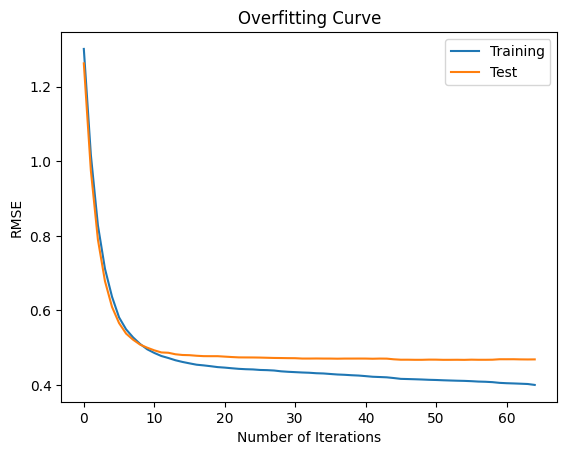

In [19]:
model = XGBRegressor(n_estimators=100, reg_lambda=2, alpha=1.5, eval_metric="rmse", early_stopping_rounds=10)

# Train the model with eval_set for tracking evaluation metrics
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Get predictions for training and test sets
pred_train = model.predict(X_train)
predictions = model.predict(X_test)

# Get the training history from the model's evaluation result
results = model.evals_result()

train_metric = results["validation_0"]["rmse"]
test_metric = results["validation_1"]["rmse"]

# Plot the overfitting curve
plt.plot(train_metric, label="Training")
plt.plot(test_metric, label="Test")
plt.xlabel("Number of Iterations")
plt.ylabel("RMSE")
plt.title("Overfitting Curve")
plt.legend()
plt.show()


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

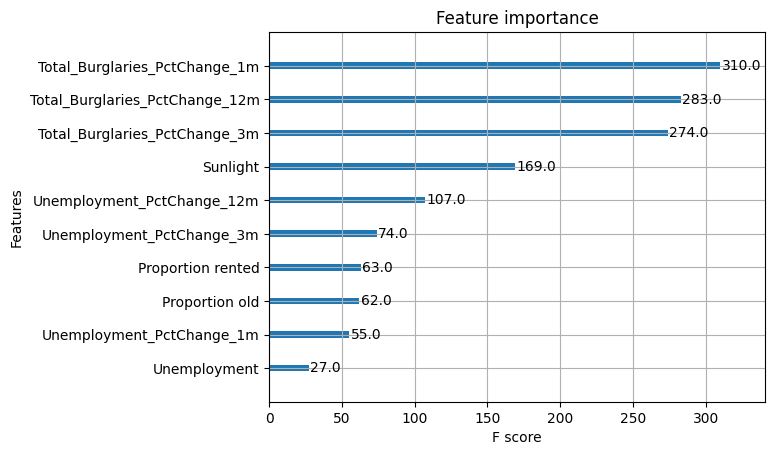

In [20]:

%matplotlib inline
xgb.plot_importance(model, ax=plt.gca(), max_num_features=10)
#Plotting the most important featurs

In [21]:
pred_train = model.predict(X_train)

predictions = model.predict(X_test)

In [22]:
# Calculate the train performance metrics
mse_train = mean_squared_error(y_train, pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
medae_train = median_absolute_error(y_train, pred_train)

# Calculate the test performance metrics
mse_test = mean_squared_error(y_test, predictions)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
medae_test = median_absolute_error(y_test, predictions)

# Create a dictionary with the train and test metric names and values
metrics = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R^2', "MedAE"],
    'Train Value': [mse_train, rmse_train, mae_train, r2_train, medae_train],
    'Test Value': [mse_test, rmse_test, mae_test, r2_test, medae_test]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Train Value,Test Value
0,MSE,0.168930,0.218468
1,RMSE,0.411010,0.467405
2,MAE,0.194326,0.221496
3,R^2,0.921546,0.894257
4,MedAE,0.080884,0.099214


In [23]:
df_date_lsoa_burg_temp = df_temp_merged_clean_test[['LSOA code', 'Month', 'Total Burglaries']].reset_index(drop=True, inplace=False)
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
predictions_df[['LSOA code', 'Month', 'Total Burglaries']] = df_date_lsoa_burg_temp
predictions_df

,Prediction,LSOA code,Month,Total Burglaries
0,1.744162,E01000115,2019-01-01,2.0
1,0.794186,E01000115,2019-02-01,1.0
2,2.883860,E01000115,2019-03-01,3.0
3,1.022066,E01000115,2019-04-01,1.0
4,0.470710,E01000115,2019-05-01,1.0
...,...,...,...,...
2527,1.167035,E01033573,2019-12-01,3.0
2528,1.210857,E01033573,2019-07-01,2.0
2529,3.213663,E01033573,2019-09-01,3.0
2530,-0.042077,E01033573,2019-06-01,0.0


In [24]:
# Load your DataFrame
df = predictions_df

# Normalize the 'Prediction' column
df['Prediction_Normalized'] = (df['Prediction'] - df['Prediction'].mean()) / df['Prediction'].std()

# Normalize the 'Total Burglaries' column
df['Total_Burglaries_Normalized'] = (df['Total Burglaries'] - df['Total Burglaries'].mean()) / df['Total Burglaries'].std()

# Add a small amount of noise to ensure uniqueness
epsilon = 1e-8
df['Prediction_Normalized'] += np.random.uniform(-epsilon, epsilon, len(df))
df['Total_Burglaries_Normalized'] += np.random.uniform(-epsilon, epsilon, len(df))

# Calculate the severity levels based on the normalized values
df['Prediction_Severity_Norm'] = pd.qcut(df['Prediction_Normalized'], q=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
df['Burglaries_Severity_Norm'] = pd.qcut(df['Total_Burglaries_Normalized'], q=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Convert the severity columns to integer type
df['Prediction_Severity'] = df['Prediction_Severity_Norm'].astype(int)
df['Burglaries_Severity'] = df['Burglaries_Severity_Norm'].astype(int)


predictions_df.to_csv(dataDir().joinpath('predicted_df.csv'))


In [25]:
X_test[0:1]

,Proportion rented,Sunlight,Unemployment,Proportion old,Unemployment_PctChange_1m,Total_Burglaries_PctChange_1m,Unemployment_PctChange_3m,Total_Burglaries_PctChange_3m,Unemployment_PctChange_12m,Total_Burglaries_PctChange_12m,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
33,0.09375,1.740893,5.0,0.104938,0.0,100.0,0.0,-50.0,-50.0,100.0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
model.predict(X_test[0:1])



array([1.7441622], dtype=float32)

In [27]:
y_test[0:1]

,Total Burglaries
33,2.0


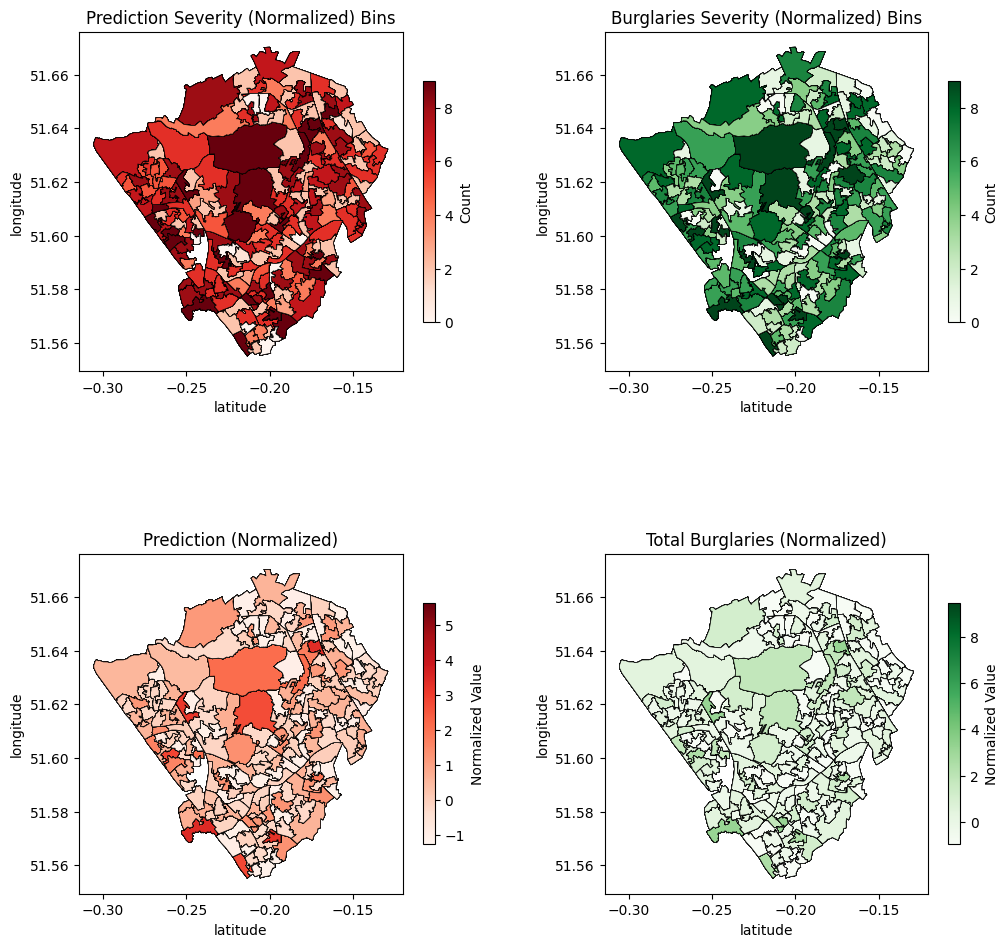

In [28]:
import geopandas as gpd
import pandas as pd
import os
import glob
from shapely.geometry import Polygon

# Load the GeoJSON file containing LSOA boundaries and extract the necessary columns
geo_LSOA = gpd.read_file(dataDir().joinpath('files_for_map/barnet_lsoa.geojson'))
geo_LSOA = geo_LSOA[['geometry', 'lsoa11cd']]
geo_LSOA.rename(columns={'lsoa11cd': 'LSOA code'}, inplace=True)

# Merge the LSOA data with the predictions DataFrame
counts_per_LSOA = predictions_df
merged_cpl_geo = pd.merge(geo_LSOA, counts_per_LSOA, on=['LSOA code'])

# Create subplots for 2x2 visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot the first map - Prediction_Severity_Norm
merged_cpl_geo.plot(column='Prediction_Severity_Norm', cmap='Reds', edgecolor='black', linewidth=0.5, ax=axs[0, 0])
axs[0, 0].set_title('Prediction Severity (Normalized) Bins')
sm1 = plt.cm.ScalarMappable(cmap='Reds')
sm1.set_array(merged_cpl_geo['Prediction_Severity_Norm'])
cbar1 = plt.colorbar(sm1, orientation='vertical', shrink=0.6, ax=axs[0, 0])
cbar1.set_label('Count')
axs[0, 0].set_xlabel('latitude')
axs[0, 0].set_ylabel('longitude')

# Plot the second map - Burglaries_Severity_Norm
merged_cpl_geo.plot(column='Burglaries_Severity_Norm', cmap='Greens', edgecolor='black', linewidth=0.5, ax=axs[0, 1])
axs[0, 1].set_title('Burglaries Severity (Normalized) Bins')
sm2 = plt.cm.ScalarMappable(cmap='Greens')
sm2.set_array(merged_cpl_geo['Burglaries_Severity_Norm'])
cbar2 = plt.colorbar(sm2, orientation='vertical', shrink=0.6, ax=axs[0, 1])
cbar2.set_label('Count')
axs[0, 1].set_xlabel('latitude')
axs[0, 1].set_ylabel('longitude')

# Plot the third map - Prediction_Normalized
merged_cpl_geo.plot(column='Prediction_Normalized', cmap='Reds', edgecolor='black', linewidth=0.5, ax=axs[1, 0])
axs[1, 0].set_title('Prediction (Normalized)')
sm3 = plt.cm.ScalarMappable(cmap='Reds')
sm3.set_array(merged_cpl_geo['Prediction_Normalized'])
cbar3 = plt.colorbar(sm3, orientation='vertical', shrink=0.6, ax=axs[1, 0])
cbar3.set_label('Normalized Value')
axs[1, 0].set_xlabel('latitude')
axs[1, 0].set_ylabel('longitude')

# Plot the fourth map - Total_Burglaries_Normalized
merged_cpl_geo.plot(column='Total_Burglaries_Normalized', cmap='Greens', edgecolor='black', linewidth=0.5, ax=axs[1, 1])
axs[1, 1].set_title('Total Burglaries (Normalized)')
sm4 = plt.cm.ScalarMappable(cmap='Greens')
sm4.set_array(merged_cpl_geo['Total_Burglaries_Normalized'])
cbar4 = plt.colorbar(sm4, orientation='vertical', shrink=0.6, ax=axs[1, 1])
cbar4.set_label('Normalized Value')
axs[1, 1].set_xlabel('latitude')
axs[1, 1].set_ylabel('longitude')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the plot
plt.show()


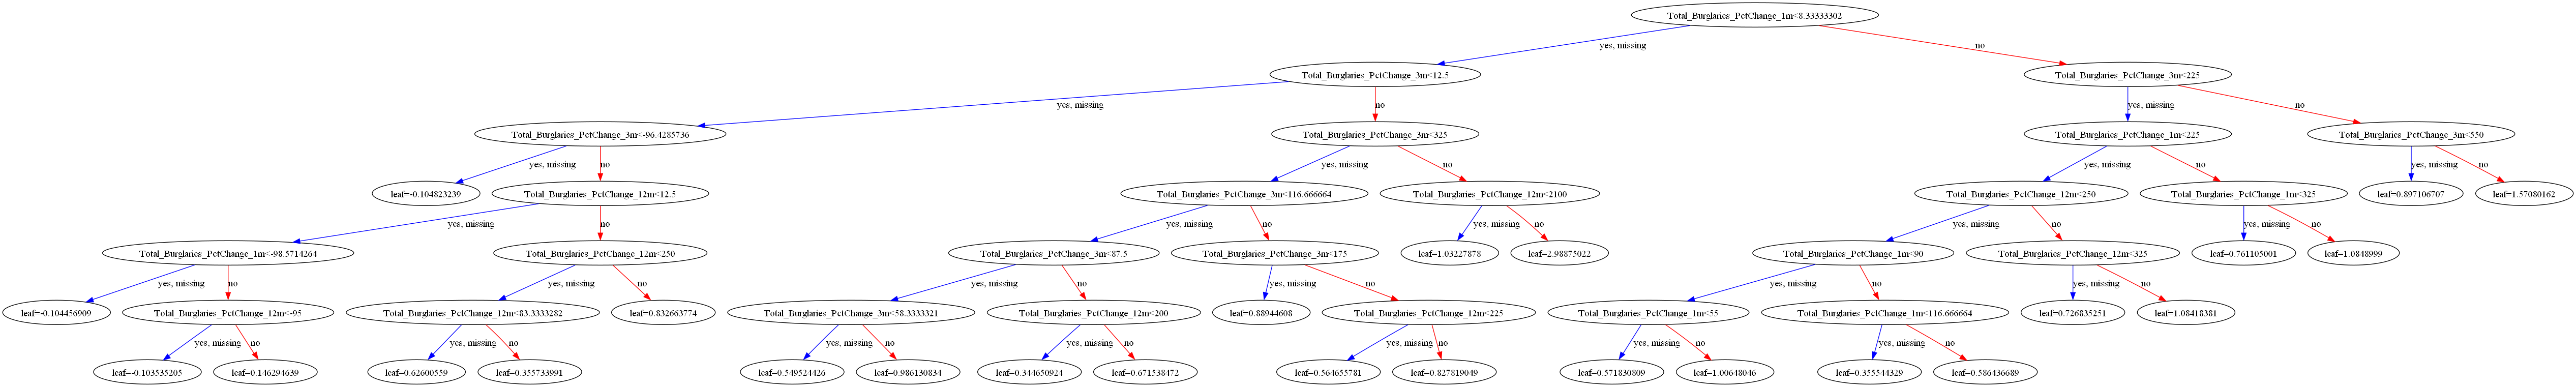

In [29]:


# Convert a single tree to DOT format
tree = xgb.to_graphviz(model, num_trees=1)
tree.format = 'png'  # Set the output format (e.g., png, pdf, svg)

# Save the tree as an image
tree.render("tree")  # Specify the output file name and DPI

# Display the saved image
Image(filename="tree.png")


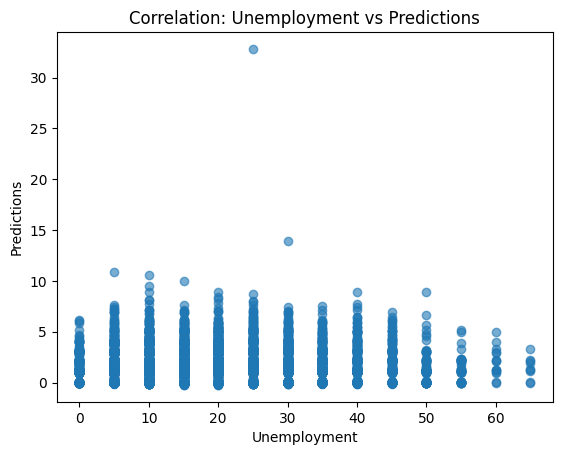

In [30]:

feature_name='Unemployment'
# Get the feature values from the feature matrix
feature_values = X_train[feature_name]

predictions = model.predict(X_train)

# Create the scatter plot
plt.scatter(feature_values, predictions, alpha=0.6)
plt.xlabel(feature_name)
plt.ylabel('Predictions')
plt.title('Correlation: {} vs Predictions'.format(feature_name))
plt.show()


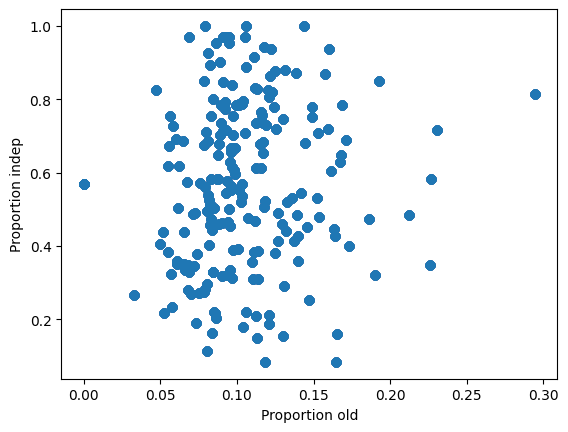

In [31]:

feature_name='Proportion old'
# Get the feature values from the feature matrix
feature_values = temp_merged_clean[feature_name]

predictions = temp_merged_clean['Proportion of indep']

# Create the scatter plot
plt.scatter(feature_values, predictions, alpha=0.6)
plt.xlabel(feature_name)
plt.ylabel('Proportion indep')
plt.show()


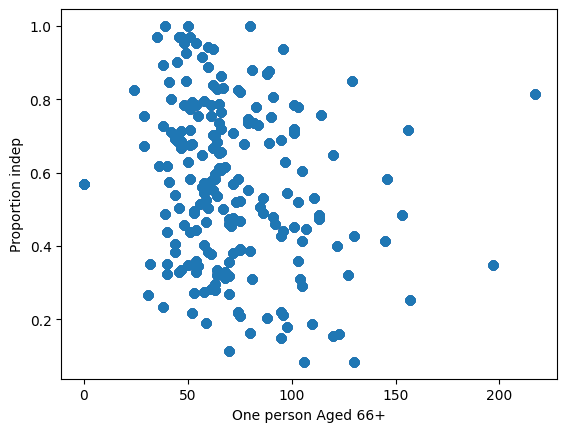

In [32]:

feature_name='One person Aged 66+'
# Get the feature values from the feature matrix
feature_values = temp_merged_clean[feature_name]

predictions = temp_merged_clean['Proportion of indep']

# Create the scatter plot
plt.scatter(feature_values, predictions, alpha=0.6)
plt.xlabel(feature_name)
plt.ylabel('Proportion indep')
plt.show()


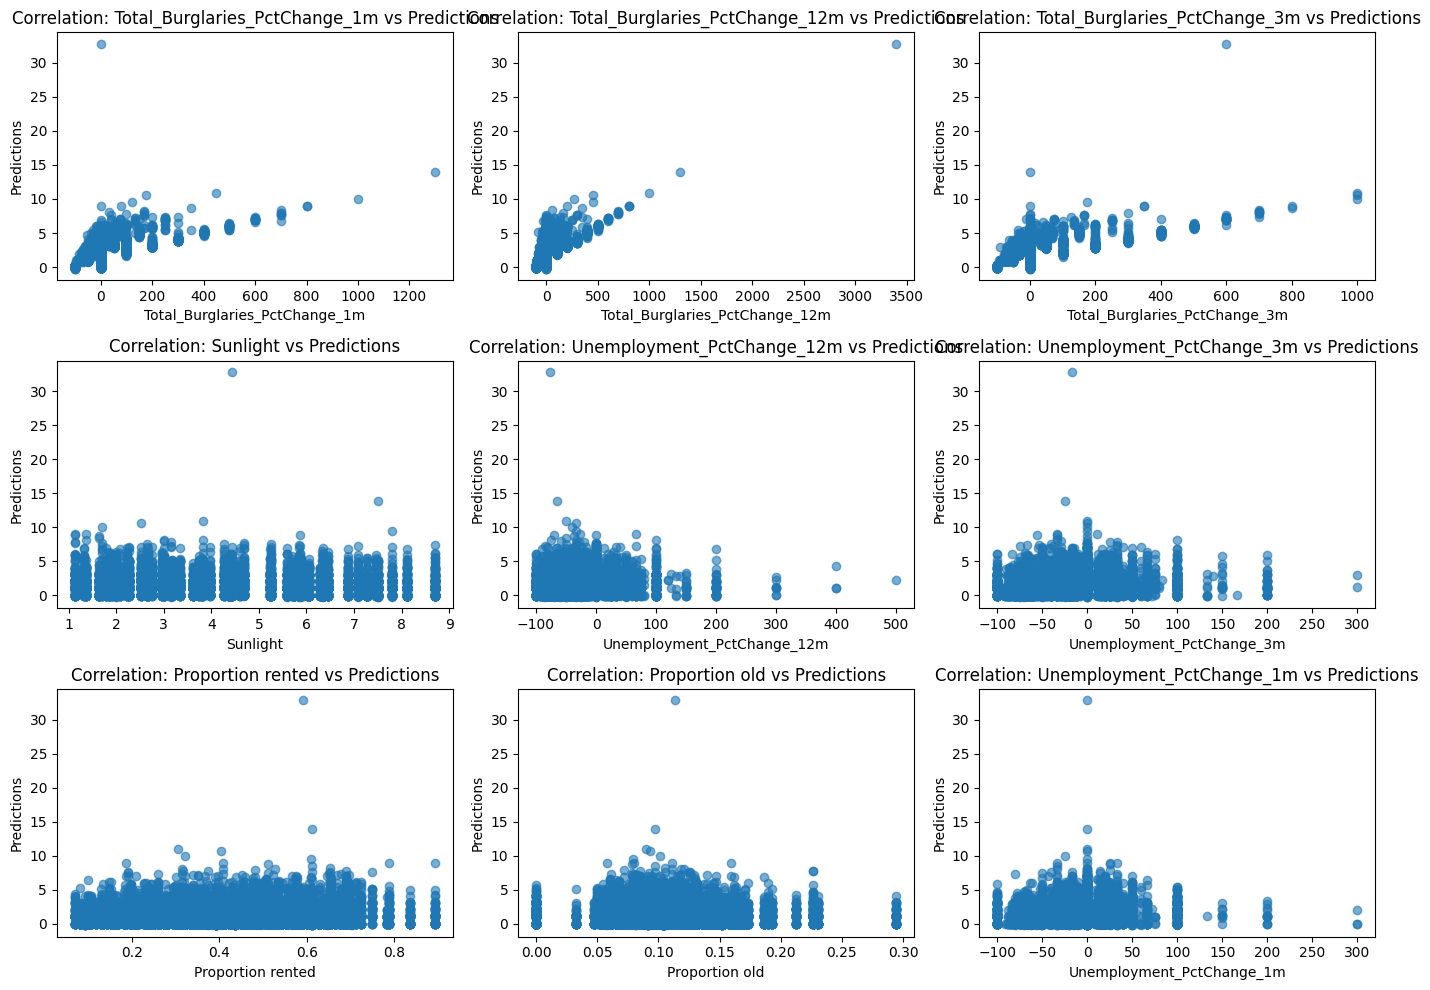

In [33]:
import matplotlib.pyplot as plt

# Get the importance scores of all features
importance_scores = model.get_booster().get_score(importance_type='weight')

# Sort the features based on their importance scores in descending order
sorted_features = sorted(importance_scores, key=importance_scores.get, reverse=True)

# Get the top N most important features
N = 9  # Number of top features to consider
top_features = sorted_features[:N]

# Define the subplot grid dimensions
n_rows = 3
n_cols = 3

# Define the figure size and spacing
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Iterate over the top N important features
for i, feature_name in enumerate(top_features):
    feature_values = X_train[feature_name]  # Get the feature values from the feature matrix
    predictions = model.predict(X_train)  # Get the model predictions
    
    # Determine the subplot position
    row = i // n_cols
    col = i % n_cols
    
    # Plot the feature values against the predictions
    axes[row, col].scatter(feature_values, predictions, alpha=0.6)
    axes[row, col].set_xlabel(feature_name)
    axes[row, col].set_ylabel('Predictions')
    axes[row, col].set_title('Correlation: {} vs Predictions'.format(feature_name))

# Hide empty subplots if the number of features is less than n_rows x n_cols
if N < n_rows * n_cols:
    for i in range(N, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')


plt.tight_layout()
plt.show()
